# **AutoDS**

---

<font size = 4> Deep-STORM is a neural network capable of image reconstruction from high-density single-molecule localization microscopy (SMLM), first published in 2018 by [Nehme *et al.* in Optica](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-5-4-458). The architecture used here is a U-Net based network without skip connections. This network allows image reconstruction of 2D super-resolution images, in a supervised training manner. The network is trained using simulated high-density SMLM data for which the ground-truth is available. These simulations are obtained from random distribution of single molecules in a field-of-view and therefore do not imprint structural priors during training. The network output a super-resolution image with increased pixel density (typically upsampling factor of 8 in each dimension).

<font size = 4> AutoDS is an extension of Deep-STORM automating the reconstruction process and aleviating the need in human intervension. This is done by automatic detection of the experimental condition in the analyzed videos and automatic selection of a Deep-STORM model out of a set of pre-trained model for the data processing.

<font size = 4> Additionally, AutoDS pipeline splits each input frame into patches and enables processing of different regions in the field-of-view with different models. This mechanism led to an improvment in the reconstruction quality beyond the capabilities of Deep-STORM.


# **Before getting started**
---
<font size = 4> This notebook contains the code required only for training of AutoDS models. For inference please follow this link: <font color = red> (add a link)

# **Mount Google Drive**
---
Running the next cell will mount your google drive

In [2]:
#@markdown Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#@markdown #1. Run this cell to install dependencies
Notebook_version = '2.0'
Network = 'AutoDS'

!pip install fpdf
# Import keras modules and libraries
import os
import math
import time
import shutil
from tqdm import tqdm
from fpdf import FPDF

import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter, zoom
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Activation, UpSampling2D, Conv2D,
                                     MaxPooling2D, BatchNormalization)
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau

#Create a variable to get and store relative base path
base_path = os.getcwd()

def gaussian_interpolation_batch(data_batch, scale, sigma=1):
    """
    Applies Gaussian interpolation (smoothing and upsampling) to a batch of images.

    Parameters:
    - data_batch: A numpy array of shape (batch_size, height, width), where each entry is an image.
    - scale: The scaling factor for upsampling.
    - sigma: The standard deviation for the Gaussian filter (default is 1).

    Returns:
    - upsampled_data_batch: A numpy array containing the upsampled images.
    """
    upsampled_data_batch = []

    for data in data_batch:
        # Apply Gaussian filter to each image in the batch
        smoothed_data = gaussian_filter(data, sigma=sigma)

        # Upsample the smoothed image
        upsampled_data = zoom(smoothed_data, scale, order=3)  # Using cubic interpolation for smooth upsampling
        upsampled_data_batch.append(upsampled_data)

    # Convert the list of upsampled images back into a numpy array
    return np.array(upsampled_data_batch)

def project_01(im):
    im = np.squeeze(im)
    return (im - im.min()) / (im.max() - im.min())

def normalize_im(im, dmean, dstd):
    return (np.squeeze(im) - dmean) / dstd

class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs.get('loss'))

def gaussian_kernel(shape=(7, 7), sigma=1):
    x, y = np.meshgrid(np.linspace(-1, 1, shape[0]), np.linspace(-1, 1, shape[1]))
    kernel = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return kernel.astype(np.float32) / np.sum(kernel)

gfilter = tf.constant(gaussian_kernel(), dtype=tf.float32)[..., None, None]

def custom_loss(input_shape):
    def loss_fn(y_true, y_pred):
        heatmap_pred = tf.nn.conv2d(y_pred, gfilter, strides=1, padding='SAME')
        loss_heatmaps = tf.reduce_mean(tf.square(y_true - heatmap_pred))
        loss_spikes = tf.reduce_mean(tf.abs(y_pred))
        return loss_heatmaps + loss_spikes

    return loss_fn

def conv_bn_relu(filters, kernel_size, name):
    def layer(input):
        conv = Conv2D(filters, kernel_size, padding="same", use_bias=False, kernel_initializer="orthogonal",
                      name=f'conv-{name}')(input)
        norm = BatchNormalization(name=f'BN-{name}')(conv)
        return Activation("relu", name=f'Relu-{name}')(norm)

    return layer

def CNN(input, name_prefix):
    f1 = conv_bn_relu(32, (3, 3), f'{name_prefix}F1')(input)
    p1 = MaxPooling2D(pool_size=(2, 2), name=f'{name_prefix}Pool1')(f1)
    f2 = conv_bn_relu(64, (3, 3), f'{name_prefix}F2')(p1)
    p2 = MaxPooling2D(pool_size=(2, 2), name=f'{name_prefix}Pool2')(f2)
    f3 = conv_bn_relu(128, (3, 3), f'{name_prefix}F3')(p2)
    p3 = MaxPooling2D(pool_size=(2, 2), name=f'{name_prefix}Pool3')(f3)
    f4 = conv_bn_relu(512, (3, 3), f'{name_prefix}F4')(p3)
    u1 = UpSampling2D(size=(2, 2), name=f'{name_prefix}Upsample1')(f4)
    f5 = conv_bn_relu(128, (3, 3), f'{name_prefix}F5')(u1)
    u2 = UpSampling2D(size=(2, 2), name=f'{name_prefix}Upsample2')(f5)
    f6 = conv_bn_relu(64, (3, 3), f'{name_prefix}F6')(u2)
    u3 = UpSampling2D(size=(2, 2), name=f'{name_prefix}Upsample3')(f6)
    return conv_bn_relu(32, (3, 3), f'{name_prefix}F7')(u3)

def CNN_upsample(input, upsampling_factor):
    # Encoder
    x = Conv2D(32, (3, 3), padding='same', name="F1")(input)
    x = BatchNormalization(name="BN_1")(x)
    x = Activation('relu',name="ReLU_1")(x)

    x = Conv2D(64, (3, 3), padding='same', name="F2")(x)
    x = BatchNormalization(name="BN_2")(x)
    x = Activation('relu', name="ReLU_2")(x)

    x = Conv2D(128, (3, 3), padding='same', name="F3")(x)
    x = BatchNormalization(name="BN_3")(x)
    x = Activation('relu', name="ReLU_3")(x)

    x = Conv2D(256, (3, 3), padding='same', name="F4")(x)
    x = BatchNormalization(name="BN_4")(x)
    x = Activation('relu', name="ReLU_4")(x)

    # Decoder
    x = Conv2D(128, (3, 3), padding='same', name="F5")(x)
    x = BatchNormalization(name="BN_5")(x)
    x = Activation('relu', name="ReLU_5")(x)

    x = Conv2D(64, (3, 3), padding='same', name="F6")(x)
    x = BatchNormalization(name="BN_6")(x)
    x = Activation('relu', name="ReLU_6")(x)

    for ind, scale in enumerate(range(int(np.log2(upsampling_factor)))):
        x = UpSampling2D(size=(2, 2), interpolation='bilinear', name="upsample_{}".format(ind+1))(x)
        x = Conv2D(32, (5, 5), padding='same', name="conv_upsample{}".format(ind+1))(x)
        x = BatchNormalization(name="BN_upsample{}".format(ind+1))(x)
        x = Activation('relu', name="ReLU_upsample{}".format(ind+1))(x)

    return x

def build_model_upsample(input_shape, lr=0.001, upsampling_factor=2):
    input_ = Input (shape=input_shape)
    act_ = CNN_upsample(input_, upsampling_factor)
    density_pred = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same",
                                  activation="linear", use_bias = False,
                                  kernel_initializer="Orthogonal",name='Prediction')(act_)
    model = Model (inputs= input_, outputs=density_pred)
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss = custom_loss(input_shape))
    return model

def train_model(patches, heatmaps, model_path, epochs, batch_size, val_split=0.3, lr=0.001, pretrained_path='', upsampling_factor=2):
    X_train, X_val, y_train, y_val = train_test_split(patches, heatmaps, test_size=val_split, random_state=42)
    X_train, X_val, y_train, y_val = [x.astype('float32') for x in [X_train, X_val, y_train, y_val]]

    X_train = X_train.reshape(-1, *X_train.shape[1:], 1)
    X_val = X_val.reshape(-1, *X_val.shape[1:], 1)

    '''mean_train, std_train = X_train.mean(), X_train.std()
    X_train = normalize_im(X_train, mean_train, std_train).reshape(-1, *X_train.shape[1:], 1)
    X_val = normalize_im(X_val, mean_train, std_train).reshape(-1, *X_val.shape[1:], 1)'''
    y_train, y_val = y_train[..., None], y_val[..., None]

    if pretrained_path and os.path.exists(pretrained_path):
        model = load_model(pretrained_path, compile=False)
        prev_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        print(f"Loaded pretrained model from {pretrained_path} with learning rate {prev_lr}")
        model.compile(optimizer=Adam(learning_rate=prev_lr), loss=custom_loss(X_train.shape[1:]))
    else:
        model = build_model_upsample(X_train.shape[1:], lr, upsampling_factor)

    callbacks = [
        ModelCheckpoint(filepath=os.path.join(model_path, "best_weights.h5"), save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)
    ]

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)
    model.save(os.path.join(model_path, 'final_model.h5'))

    # Save datasets to a matfile to open later in matlab
    mdict = {"upsampling_factor": upsampling_factor,
             "Normalization factor": L2_weighting_factor,
             "pixel_size": pixel_size,
             "wavelength": wavelength,
             "numerical_aperture": numerical_aperture}
    sio.savemat(os.path.join(model_path,"model_metadata.mat"), mdict)

    return history

# Normalization functions from Martin Weigert used in CARE
def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)

def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):#dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x

def norm_minmse(gt, x, normalize_gt=True):
    """This function is adapted from Martin Weigert"""

    """
    normalizes and affinely scales an image pair such that the MSE is minimized

    Parameters
    ----------
    gt: ndarray
        the ground truth image
    x: ndarray
        the image that will be affinely scaled
    normalize_gt: bool
        set to True of gt image should be normalized (default)
    Returns
    -------
    gt_scaled, x_scaled
    """
    if normalize_gt:
        gt = normalize(gt, 0.1, 99.9, clip=False).astype(np.float32, copy = False)
    x = x.astype(np.float32, copy=False) - np.mean(x)
    #x = x - np.mean(x)
    gt = gt.astype(np.float32, copy=False) - np.mean(gt)
    #gt = gt - np.mean(gt)
    scale = np.cov(x.flatten(), gt.flatten())[0, 1] / np.var(x.flatten())
    return gt, scale * x

def FromLoc2Image_SimpleHistogram(xc_array, yc_array, image_size = (64,64), pixel_size = 100):
  w = image_size[0]
  h = image_size[1]
  locImage = np.zeros((image_size[0],image_size[1]) )
  n_locs = len(xc_array)

  for e in range(n_locs):
    locImage[int(max(min(round(yc_array[e]/pixel_size),w-1),0))][int(max(min(round(xc_array[e]/pixel_size),h-1),0))] += 1

  return locImage

def FromLoc2Image_Erf(xc_array, yc_array, photon_array, sigma_array, image_size = (64,64), pixel_size = 100):
  w = image_size[0]
  h = image_size[1]
  erfImage = np.zeros((w, h))
  for ij in range(w*h):
    j = int(ij/w)
    i = ij - j*w
    for (xc, yc, photon, sigma) in zip(xc_array, yc_array, photon_array, sigma_array):
      # Don't bother if the emitter has photons <= 0 or if Sigma <= 0
      if (sigma > 0) and (photon > 0):
        S = sigma*math.sqrt(2)
        x = i*pixel_size - xc
        y = j*pixel_size - yc
        # Don't bother if the emitter is further than 4 sigma from the centre of the pixel
        if (x+pixel_size/2)**2 + (y+pixel_size/2)**2 < 16*sigma**2:
          ErfX = math.erf((x+pixel_size)/S) - math.erf(x/S)
          ErfY = math.erf((y+pixel_size)/S) - math.erf(y/S)
          erfImage[j][i] += 0.25*photon*ErfX*ErfY
  return erfImage

def generate_training_report(model_path, simParameters, history):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    pdf.set_font("Arial", 'B', 16)
    pdf.cell(200, 10, "Training Report", ln=True, align='C')
    pdf.ln(10)

    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, f"Model path: {model_path}", ln=True)
    pdf.ln(5)

    for key, value in simParameters.items():
        pdf.cell(200, 10, f"{key}: {value}", ln=True)

    pdf.ln(10)
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(200, 10, "Loss Curve", ln=True)
    pdf.ln(5)

    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    loss_plot_path = os.path.join(model_path, "loss_curve.png")
    plt.savefig(loss_plot_path)
    pdf.image(loss_plot_path, x=10, y=None, w=180)

    pdf_output_path = os.path.join(model_path, "training_report.pdf")
    pdf.output(pdf_output_path)
    print(f"Training report saved at {pdf_output_path}")

print('--------------------------------')
print('DeepSTORM+ installation complete.')

if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.')
  print('Did you change your runtime ?')
  print('If the runtime settings are correct then Google did not allocate GPU to your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')

# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

# print the tensorflow version
print('Tensorflow version is ' + str(tf.__version__))

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=bf15fa25f1a7c245d50edf286898779b362729f47abce0882bf9b860285c8152
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf
--------------------------------
DeepSTORM+ installation complete.
You have GPU access
Tensorflow version is 2.18.0


-----------------------------------------------------------
Number of molecules / FOV: 27.48 +/- 9.16
Gaussian PSF sigma: 124.77 nm
Final image size: 40x40 (4.28um x4.28 um)
-----------------------------------------------------------


100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


SNR: 4.59 +/- 1.32
Time elapsed: 0.0 hour(s) 0.0 min(s) 6.4 sec(s)
Generating 1000 patches of 30x30
Total number of localizations: 2853
Density: 1.56 locs/um^2
-----------------------------------------------------------


100%|██████████| 100/100 [00:00<00:00, 161.79it/s]


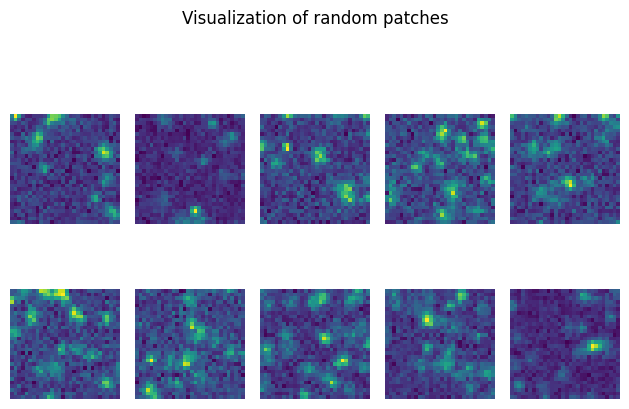

!! WARNING: Training set size is below 5K - Consider simulating more images in ThunderSTORM. !!
Number of patches skipped due to low density: 0
1000 patches were generated.
Time elapsed: 0.0 hour(s) 0.0 min(s) 1 sec(s)


In [10]:
from re import L
# ---------------------------- User input ----------------------------
#@markdown #2. Generate simulated dataset
#@markdown ---
#@markdown Camera settings:
FOV_size = 4280 #@param {type:"number"}
pixel_size = 107 #@param {type:"number"}
ADC_per_photon_conversion = 1 #@param {type:"number"}
ReadOutNoise_ADC = 20 #@param {type:"number"}
ADC_offset = 50 #@param {type:"number"}

#@markdown Acquisition settings:
emitter_density = 1.5 #@param {type:"number"}
emitter_density_std = 0.5 #@param {type:"number"}

number_of_frames = 100 #@param {type:"integer"}

wavelength = 715 #@param {type:"number"}
numerical_aperture = 1.49 #@param {type:"number"}

sigma_std = 20 #@param {type:"number"}
n_photons = 900 #@param {type:"number"}
n_photons_std = 100 #@param {type:"number"}

# ---------------------------- Variable initialisation ----------------------------
# Start the clock to measure how long it takes
start = time.time()

print('-----------------------------------------------------------')
n_molecules = emitter_density * FOV_size * FOV_size /10 ** 6
n_molecules_std = emitter_density_std * FOV_size * FOV_size / 10 ** 6
print('Number of molecules / FOV: ' + str(round(n_molecules, 2))+' +/- '+str((round(n_molecules_std, 2))))

# FWHM = 2 * sqrt(2 * ln(2)) * sigma ---> sigma = FWHM / 2.355 = 0.61 * wavelength / 2.355 * NA
sigma = 0.26 * wavelength / numerical_aperture
print('Gaussian PSF sigma: '+ str(round(sigma, 2)) + ' nm')

M = round(FOV_size / pixel_size)
N = round(FOV_size / pixel_size)

FOV_size = M * pixel_size
print('Final image size: ' + str(M) + 'x' + str(M) + ' (' + str(round(FOV_size / 1000, 3)) + 'um x' + str(round(FOV_size / 1000, 3)) + ' um)')

np.random.seed(1)
display_upsampling = 8 # used to display the loc map here
NoiseFreeImages = np.zeros((number_of_frames, M, M))
locImage = np.zeros((number_of_frames, display_upsampling * M, display_upsampling * N))

frames = []
all_xloc = []
all_yloc = []
all_photons = []
all_sigmas = []

# ---------------------------- Main simulation loop ----------------------------
print('-----------------------------------------------------------')
for f in tqdm(range(number_of_frames)):
  # Define the coordinates of emitters by randomly distributing them across the FOV
  n_mol = int(max(round(np.random.normal(n_molecules, n_molecules_std, size=1)[0]), 0))
  x_c = np.random.uniform(low=0.0, high=FOV_size, size=n_mol)
  y_c = np.random.uniform(low=0.0, high=FOV_size, size=n_mol)
  photon_array = np.random.normal(n_photons, n_photons_std, size=n_mol)
  sigma_array = np.random.normal(sigma, sigma_std, size=n_mol)

  all_xloc += x_c.tolist()
  all_yloc += y_c.tolist()
  frames += ((f + 1)*np.ones(x_c.shape[0])).tolist()
  all_photons += photon_array.tolist()
  all_sigmas += sigma_array.tolist()

  locImage[f] = FromLoc2Image_SimpleHistogram(x_c, y_c, image_size=(N * display_upsampling, M * display_upsampling), pixel_size=pixel_size / display_upsampling)
  NoiseFreeImages[f] = FromLoc2Image_Erf(x_c, y_c, photon_array, sigma_array, image_size=(M,M), pixel_size=pixel_size)

# ---------------------------- Create DataFrame fof localization file ----------------------------
# Table with localization info as dataframe output
LocData = pd.DataFrame()
LocData["frame"] = frames
LocData["x [nm]"] = all_xloc
LocData["y [nm]"] = all_yloc
LocData["Photon #"] = all_photons
LocData["Sigma [nm]"] = all_sigmas
LocData.index += 1  # set indices to start at 1 and not 0 (same as ThunderSTORM)

# ---------------------------- Estimation of SNR ----------------------------
n_frames_for_SNR = 100
M_SNR = 10
x_c = np.random.uniform(low=0.0, high=pixel_size*M_SNR, size=n_frames_for_SNR)
y_c = np.random.uniform(low=0.0, high=pixel_size*M_SNR, size=n_frames_for_SNR)
photon_array = np.random.normal(n_photons, n_photons_std, size=n_frames_for_SNR)
sigma_array = np.random.normal(sigma, sigma_std, size=n_frames_for_SNR)

SNR = np.zeros(n_frames_for_SNR)
for i in range(n_frames_for_SNR):
  SingleEmitterImage = FromLoc2Image_Erf(np.array([x_c[i]]), np.array([x_c[i]]), np.array([photon_array[i]]), np.array([sigma_array[i]]), (M_SNR, M_SNR), pixel_size)
  Signal_photon = np.max(SingleEmitterImage)
  Noise_photon = math.sqrt((ReadOutNoise_ADC / ADC_per_photon_conversion) ** 2 + Signal_photon)
  SNR[i] = Signal_photon/Noise_photon

print('SNR: ' + str(round(np.mean(SNR), 2)) + ' +/- '+str(round(np.std(SNR), 2)))
# ---------------------------- ----------------------------

# Table with info
savedParameters = {}
savedParameters["FOV size (nm)"] = FOV_size
savedParameters["Pixel size (nm)"] = pixel_size
savedParameters["ADC/photon"] = ADC_per_photon_conversion
savedParameters["Read-out noise (ADC)"] = ReadOutNoise_ADC
savedParameters["Constant offset (ADC)"] = ADC_offset

savedParameters["Emitter density (emitters/um^2)"] = emitter_density
savedParameters["STD of emitter density (emitters/um^2)"] = emitter_density_std
savedParameters["Number of frames"] = number_of_frames

savedParameters["Wavelength (nm)"] = wavelength
savedParameters["NA"] = numerical_aperture
savedParameters["Sigma (nm)"] = sigma
savedParameters["STD of Sigma (nm)"] = sigma_std
savedParameters["Number of photons"] = n_photons
savedParameters["STD of number of photons"] = n_photons_std
savedParameters["SNR"] = np.mean(SNR)
savedParameters["STD of SNR"] = np.std(SNR)

# ---------------------------- Finish simulation ----------------------------
# Calculating the noisy image
Images = ADC_per_photon_conversion * np.random.poisson(NoiseFreeImages) + ReadOutNoise_ADC * np.random.normal(size=(number_of_frames, M, N)) + ADC_offset
Images[Images <= 0] = 0

# Convert to 16-bit or 32-bits integers
if Images.max() < (2**16-1):
  Images = Images.astype(np.uint16)
else:
  Images = Images.astype(np.uint32)

# ---------------------------- Display ----------------------------
# Displaying the time elapsed for simulation
dt = time.time() - start
minutes, seconds = divmod(dt, 60)
hours, minutes = divmod(minutes, 60)
print("Time elapsed:",hours, "hour(s)",minutes,"min(s)",round(seconds,1),"sec(s)")

# -------------------- User input --------------------
patch_size = 30 #@param {type:"integer"}
upsampling_factor = 8 #@param ["4", "8", "16"] {type:"raw"}
num_patches_per_frame = 10 #@param {type:"integer"}
min_number_of_emitters_per_patch = 0 #@param {type:"integer"}
max_num_patches = 10000 #@param {type:"integer"}
gaussian_sigma = 1 #@param {type:"integer"}

savedParameters["patch size"] = patch_size
savedParameters["upsampling factor"] = upsampling_factor
savedParameters["num_patches_per_frame"] = num_patches_per_frame
savedParameters["min_number_of_emitters_per_patch"] = min_number_of_emitters_per_patch
savedParameters["max_num_patches"] = max_num_patches
savedParameters["gaussian_sigma"] = gaussian_sigma

#@markdown Estimate the optimal normalization factor automatically?
Automatic_normalization = False #@param {type:"boolean"}
#@markdown Otherwise, it will use the following value:
L2_weighting_factor = 100 #@param {type:"number"}

# -------------------- Prepare variables --------------------
# Start the clock to measure how long it takes
start = time.time()

# Initialize some parameters
pixel_size_hr = pixel_size / int(upsampling_factor) # in nm
n_patches = min(int(number_of_frames) * int(num_patches_per_frame), int(max_num_patches))
# patch_size = int(patch_size) * int(upsampling_factor)
patch_size = int(patch_size)
patch_size_hr = patch_size * upsampling_factor

# Initialize the training patches and labels
patches = np.zeros((n_patches, patch_size, patch_size), dtype=np.float32)
spikes = np.zeros((n_patches, patch_size_hr, patch_size_hr), dtype=np.float32)
heatmaps = np.zeros((n_patches, patch_size_hr, patch_size_hr), dtype=np.float32)

# Run over all frames and construct the training examples
k = 1 # current patch count
skip_counter = 0 # number of dataset skipped due to low density
id_start = 0 # id position in LocData for current frame
print('Generating ' + str(n_patches) + ' patches of ' + str(patch_size) + 'x' + str(patch_size))

n_locs = len(LocData.index)
print('Total number of localizations: ' + str(n_locs))
density = n_locs / (M * N * number_of_frames * (0.001 * pixel_size) ** 2)
print('Density: ' + str(round(density, 2)) + ' locs/um^2')
n_locs_per_patch = density * (patch_size ** 2)

if Automatic_normalization:
  # This empirical formulae attempts to balance the loss L2 function between the background and the bright spikes
  # A value of 100 was originally chosen to balance L2 for a patch size of 2.6x2.6^2 0.1um pixel size and density of 3 (hence the 20.28), at upsampling_factor = 8
  L2_weighting_factor = 100 / math.sqrt(min(n_locs_per_patch, min_number_of_emitters_per_patch) * 8 **2 / (int(upsampling_factor) ** 2 * 20.28))
  print('Normalization factor: '+str(round(L2_weighting_factor,2)))

savedParameters["L2 weighting factor"] = L2_weighting_factor
# -------------------- Patch generation loop --------------------
print('-----------------------------------------------------------')
for (f, thisFrame) in enumerate(tqdm(Images)):

  # Upsample the frame
  # upsampledFrame = np.kron(thisFrame, np.ones((int(upsampling_factor),int(upsampling_factor))))

  thisFrame -= np.min(thisFrame)
  thisFrame[thisFrame < 0] = 0

  normFrame = normalize_im(thisFrame, thisFrame.mean(), thisFrame.std())

  # Read all the provided high-resolution locations for current frame
  DataFrame = LocData[LocData['frame'] == f + 1].copy()

  Mhr = M * upsampling_factor
  Nhr = N * upsampling_factor

  # Get the approximated locations according to the high-res grid pixel size
  Chr_emitters = [int(max(min(round(DataFrame['x [nm]'][i] / pixel_size_hr),Nhr-1), 0)) for i in range(id_start + 1,id_start + 1 + len(DataFrame.index))]
  Rhr_emitters = [int(max(min(round(DataFrame['y [nm]'][i] / pixel_size_hr),Mhr-1), 0)) for i in range(id_start + 1,id_start + 1 + len(DataFrame.index))]
  id_start += len(DataFrame.index)

  # Build Localization image
  LocImage = np.zeros((Mhr,Nhr))
  LocImage[(Rhr_emitters, Chr_emitters)] = 1

  # Here, there's a choice between the original Gaussian (classification approach) and using the erf function
  HeatMapImage = L2_weighting_factor*gaussian_filter(LocImage, float(gaussian_sigma))

  # Generate random position for the top left corner of the patch
  xc = np.random.randint(0, M-patch_size, size=num_patches_per_frame)
  yc = np.random.randint(0, N-patch_size, size=num_patches_per_frame)

  xc_hr = xc * upsampling_factor
  yc_hr = yc * upsampling_factor

  for c in range(len(xc)):
    if LocImage[xc_hr[c]:xc_hr[c] + patch_size_hr, yc_hr[c]:yc_hr[c] + patch_size_hr].sum() < min_number_of_emitters_per_patch:
      skip_counter += 1
      continue

    else:
        # Limit maximal number of training examples to 15k
      if k > max_num_patches:
        break
      else:
        # Assign the patches to the right part of the images
        patches[k-1] = normFrame[xc[c]:xc[c] + patch_size, yc[c]:yc[c] + patch_size]
        spikes[k-1] = LocImage[xc_hr[c]:xc_hr[c] + patch_size_hr, yc_hr[c]:yc_hr[c] + patch_size_hr]
        heatmaps[k-1] = HeatMapImage[xc_hr[c]:xc_hr[c] + patch_size_hr, yc_hr[c]:yc_hr[c] + patch_size_hr]
        k += 1 # increment current patch count

# Remove the empty data
patches = patches[:k-1]
spikes = spikes[:k-1]
heatmaps = heatmaps[:k-1]
n_patches = k-1
# ----------------- Visualization ------------------
num_samples = np.min([10, patches.shape[0]])
random_ind = np.random.randint(0, patches.shape[0], num_samples)
plt.figure()
plt.suptitle("Visualization of random patches")
for ind in range(num_samples):
  plt.subplot(2, num_samples//2, ind+1)
  plt.imshow(patches[random_ind[ind]])
  plt.axis('off')
plt.tight_layout()
plt.show()
# -------------------- Failsafe --------------------
# Check if the size of the training set is smaller than 5k to notify user to simulate more images using ThunderSTORM
if ((k-1) < 5000):
  print('!! WARNING: Training set size is below 5K - Consider simulating more images in ThunderSTORM. !!')

# -------------------- Displays --------------------
print('Number of patches skipped due to low density: '+str(skip_counter))
print(str(n_patches)+' patches were generated.')

# Displaying the time elapsed for training
dt = time.time() - start
minutes, seconds = divmod(dt, 60)
hours, minutes = divmod(minutes, 60)
print("Time elapsed:",hours, "hour(s)",minutes,"min(s)",round(seconds),"sec(s)")

In [11]:
#@markdown #3. Initialize training parameters

model_path = "/content/gdrive/MyDrive/DeepSTORM/model" #@param {type: "string"}
model_name = "test" #@param {type: "string"}
model_path = os.path.join(model_path, model_name)
number_of_epochs = 3 #@param {type:"integer"}
batch_size = 16 #@param {type:"integer"}

percentage_validation = 20 #@param {type:"number"}
initial_learning_rate = 0.001 #@param {type:"number"}

percentage_validation /= 100

# Pretrained model path initialised here so next cell does not need to be run
h5_file_path = ''
Use_pretrained_model = False

if not ('patches' in globals()):
  print('!! WARNING: No patches were found in memory currently. !!')

Save_path = os.path.join(model_path, model_name)
if os.path.exists(Save_path):
  print('The model folder already exists and will be overwritten.')

print('-----------------------------')
print('Training parameters set.')


# @markdown ###Loading weights from a pre-trained network

#@markdown If you chose to continue training an existing model, please specify the hd5 file path
h5_file_path = '' #@param {type: "string"}

# Display info about the pretrained model to be loaded (or not)
if Use_pretrained_model:
  print('Weights found in:')
  print(h5_file_path)
  print('will be loaded prior to training.')
else:
  print('No pretrained network will be used.')

-----------------------------
Training parameters set.
No pretrained network will be used.


Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3725
Epoch 1: val_loss improved from inf to 0.23841, saving model to /content/gdrive/MyDrive/DeepSTORM/model/test/best_weights.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - loss: 0.3706 - val_loss: 0.2384 - learning_rate: 0.0010
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2289
Epoch 2: val_loss improved from 0.23841 to 0.22697, saving model to /content/gdrive/MyDrive/DeepSTORM/model/test/best_weights.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.2289 - val_loss: 0.2270 - learning_rate: 0.0010
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2269
Epoch 3: val_loss improved from 0.22697 to 0.22594, saving model to /content/gdrive/MyDrive/DeepSTORM/model/test/best_weights.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.2269 - val_loss: 0.2259 - learning_rate: 0.0010


Time elapsed: 0.0 hour(s) 0.0 min(s) 40 sec(s)
Training report saved at /content/gdrive/MyDrive/DeepSTORM/model/test/training_report.pdf


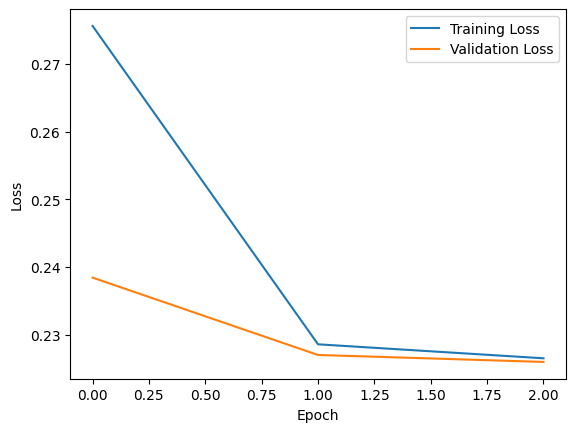

In [12]:
#@markdown #4. Start training

# Start the clock to measure how long it takes
start = time.time()

#here we check that no model with the same name already exist, if so delete
if os.path.exists(Save_path):
  shutil.rmtree(Save_path)

# Create the model folder!
os.makedirs(Save_path)

# Let's go !
train_history = train_model(patches,
                            heatmaps,
                            model_path,
                            epochs=number_of_epochs,
                            batch_size=batch_size,
                            val_split=percentage_validation,
                            lr=initial_learning_rate,
                            pretrained_path=h5_file_path,
                            upsampling_factor=upsampling_factor)


# Displaying the time elapsed for training
dt = time.time() - start
minutes, seconds = divmod(dt, 60)
hours, minutes = divmod(minutes, 60)
print("Time elapsed:",hours, "hour(s)",minutes,"min(s)",round(seconds),"sec(s)")

# export pdf after training to update the existing document
generate_training_report(model_path, savedParameters, train_history)

# **Version log**
---
<font size = 4>**v1.0**:  
---


#**Thank you for using AutoDS!**